# CAN Workshop- LFADS demo in pytorch

## Import necessary modules

In [1]:
%matplotlib inline

import torch
import torchvision
np = torch._np
import matplotlib.pyplot as plt

import os
import yaml

from lfads import LFADS_Net
from utils import read_data, load_parameters, save_parameters
import scipy.io
# plt.style.use('dark_background')

In [2]:
# Select device to train LFADS on
device = 'cuda' if torch.cuda.is_available() else 'cpu'; print('Using device: %s'%device)

Using device: cuda


## Load or Generate Data 

In [3]:
all_time =3000
Time = 100
neuron_num = 85
datax = scipy.io.loadmat("spike85_k09_6000.mat")
y_data = datax["spike85_k09_6000"][:,:all_time].T
traj = scipy.io.loadmat("trj85_k09_6000.mat")
traj = traj["trj85_k09_6000"][:,:all_time].T
if os.path.exists('./synth_data/chaotic_rnn_300'):
    data_dict = read_data('./synth_data/chaotic_rnn_300')
else:
    if not os.path.isdir('./synth_data'):
        os.mkdir('./synth_data/')
    
    from synth_data_chaotic_rnn import generate_data
    data_dict = generate_data(T= 1, dt_rnn= 0.01, dt_cal= 0.01,
                              Ninits= 400, Ntrial= 10, Ncells= 30, trainp= 0.8,
                              tau=0.025, gamma=1.5, maxRate=30, B=20,
                              seed=300, save=True)

train_data = torch.Tensor(data_dict['train_spikes']).to(device)
valid_data = torch.Tensor(data_dict['valid_spikes']).to(device)

train_truth = torch.Tensor(data_dict['train_rates']).to(device)
valid_truth = torch.tensor(data_dict['valid_rates']).to(device)

train_ds      = torch.utils.data.TensorDataset(train_data)
valid_ds      = torch.utils.data.TensorDataset(valid_data)

num_trials, num_steps, num_cells = train_data.shape
train_data[0][1][0] = 1
NRep=int(all_time/Time)
output = np.zeros((NRep,Time,neuron_num))
print(y_data.shape)
for i in range(NRep):
    output[i,:,:] = y_data[Time*i:Time*(i+1),:]
output = output.astype('float32')
output = torch.Tensor(output).to(device)
print(train_data.shape)
print(output.shape)

(3000, 85)
torch.Size([3200, 100, 30])
torch.Size([30, 100, 85])


## View example Ground Truth Firing Rates

(100, 85)


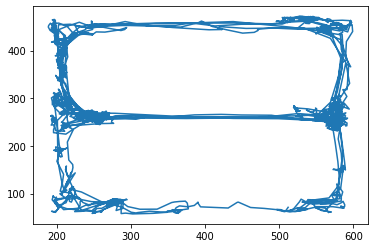

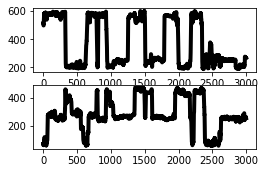

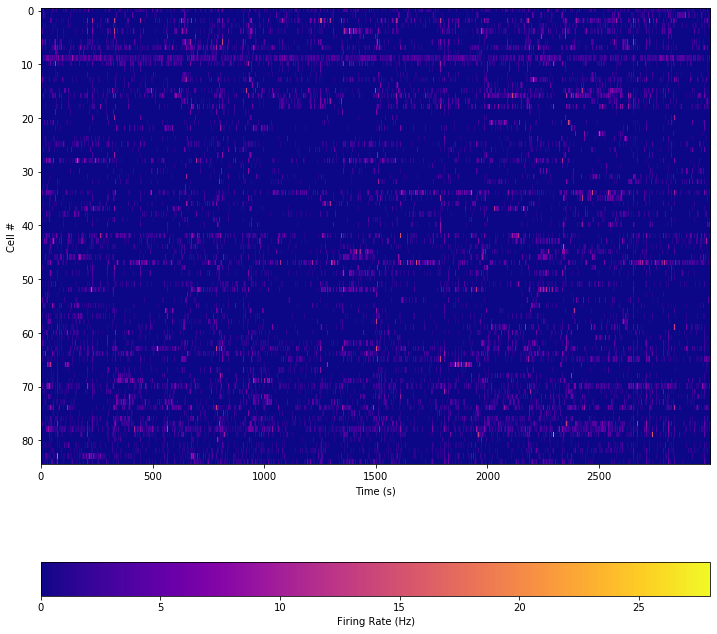

In [4]:
train_ds      = torch.utils.data.TensorDataset(output)
valid_ds      = torch.utils.data.TensorDataset(output)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(traj[:,0],traj[:,1])
plt.figure(figsize=(4, 4))
ax1 = plt.subplot(311)
ax1.plot(traj[:, 0], lw=4, color='k')

ax2 = plt.subplot(312, sharex=ax1)
ax2.plot(traj[:, 1], lw=4, color='k')    

# Z score output:
output=output.reshape(Time*NRep,neuron_num)
from scipy import stats
output = stats.zscore(output,axis=0)
output = output.reshape(NRep,Time,neuron_num)
print(output[0].shape)
plt.figure(figsize = (12,12))
plt.imshow(y_data.T, cmap=plt.cm.plasma,aspect='auto')
plt.xlabel('Time (s)')
plt.ylabel('Cell #')
plt.colorbar(orientation='horizontal', label='Firing Rate (Hz)')

## LFADS Schema
<img src='lfads_schema.png' width=800 align=left>

## Load model hyperparameters 

In [5]:
hyperparams = load_parameters('./parameters.yaml')
save_parameters(hyperparams)
hyperparams

{'dataset_name': 'chaotic_rnn',
 'run_name': 'demo',
 'g_dim': 200,
 'u_dim': 1,
 'factors_dim': 2,
 'g0_encoder_dim': 200,
 'c_encoder_dim': 128,
 'controller_dim': 128,
 'g0_prior_kappa': 0.1,
 'u_prior_kappa': 0.1,
 'keep_prob': 0.95,
 'clip_val': 5.0,
 'max_norm': 200,
 'learning_rate': 0.01,
 'learning_rate_min': 1e-05,
 'learning_rate_decay': 0.95,
 'scheduler_on': True,
 'scheduler_patience': 6,
 'scheduler_cooldown': 6,
 'kl_weight_schedule_start': 0,
 'kl_weight_schedule_dur': 2000,
 'l2_weight_schedule_start': 0,
 'l2_weight_schedule_dur': 2000,
 'epsilon': 0.1,
 'betas': (0.9, 0.99),
 'l2_gen_scale': 2000,
 'l2_con_scale': 0}

## Instantiate LFADS model

In [6]:
model = LFADS_Net(inputs_dim = neuron_num, T = Time, dt = 0.01, device=device,
                 model_hyperparams=hyperparams).to(device)

Random seed: 4874


#### Pick up where you left off (if you have a recent save) 

In [7]:
# model.load_checkpoint('recent')

## Fit model

Rule of thumb: You can usually see good fit after 200 epochs (~30 mins runtime on Thinkpad GPU, ~2.5 hours on CPU), but to see good inference of perturbation timings need to run for about 800 epochs (~2 hours on Thinkpad GPU).

Beginning training...
Epoch:    1, Step:    10, training loss: 22695.107, validation loss: 24411.791
Epoch:    2, Step:    20, training loss: 21118.062, validation loss: 21693.350
Epoch:    3, Step:    30, training loss: 19945.014, validation loss: 20835.180
Epoch:    4, Step:    40, training loss: 18340.037, validation loss: 18938.389
Epoch:    5, Step:    50, training loss: 16763.344, validation loss: 40954.637
Epoch:    6, Step:    60, training loss: 16107.064, validation loss: 15673.768
Epoch:    7, Step:    70, training loss: 14156.903, validation loss: 14289.005
Epoch:    8, Step:    80, training loss: 12906.814, validation loss: 12919.995
Epoch:    9, Step:    90, training loss: 11738.944, validation loss: 11873.188
Epoch:   10, Step:   100, training loss: 10935.952, validation loss: 11246.304
Epoch:   11, Step:   110, training loss: 10308.802, validation loss: 10475.623
Epoch:   12, Step:   120, training loss: 9816.979, validation loss: 9990.647
Epoch:   13, Step:   130, traini

Epoch:  103, Step:  1030, training loss: 8341.514, validation loss: 8387.049
Epoch:  104, Step:  1040, training loss: 8343.311, validation loss: 8384.461
Epoch:  105, Step:  1050, training loss: 8341.665, validation loss: 8393.653
Epoch:  106, Step:  1060, training loss: 8344.699, validation loss: 8388.726
Epoch:  107, Step:  1070, training loss: 8339.249, validation loss: 8381.374
Epoch:  108, Step:  1080, training loss: 8339.456, validation loss: 8384.934
Epoch:  109, Step:  1090, training loss: 8361.731, validation loss: 8404.058
Learning rate decreased to 0.00698337
Epoch:  110, Step:  1100, training loss: 8351.304, validation loss: 8371.290
Epoch:  111, Step:  1110, training loss: 8343.339, validation loss: 8392.245
Epoch:  112, Step:  1120, training loss: 8326.546, validation loss: 8374.394
Epoch:  113, Step:  1130, training loss: 8339.788, validation loss: 8378.295
Epoch:  114, Step:  1140, training loss: 8332.033, validation loss: 8362.226
Epoch:  115, Step:  1150, training los

IndexError: index 40 is out of bounds for axis 1 with size 30

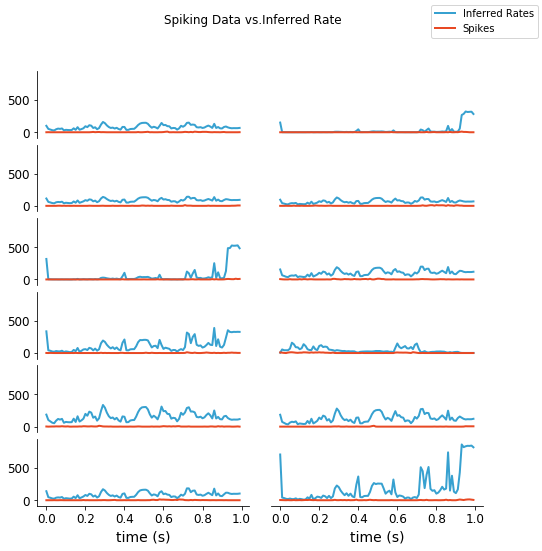

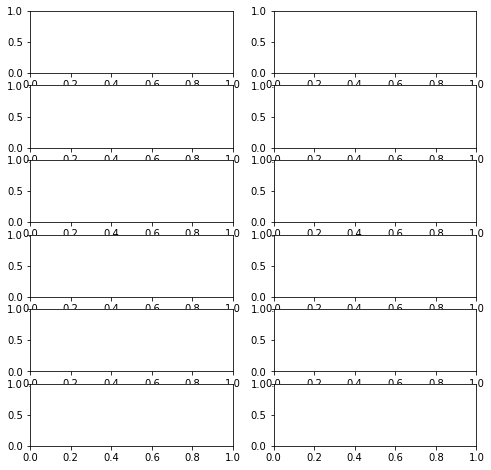

In [8]:
model.fit(train_ds, valid_ds, max_epochs=800, batch_size=3, use_tensorboard=True,
          train_truth=train_truth, valid_truth=valid_truth)

## Load checkpoint with lowest validation error 

In [ ]:
model.load_checkpoint('best')

## Plot results summary 

In [ ]:
model.plot_summary(data=valid_data, truth=valid_truth)